#Prediction of Mycotoxin levels in Corn Samples

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR

##Data Exploration and Preprocessing

###Data Uploading

In [ ]:
# Load Data
data = pd.read_csv("TASK-ML-INTERN.csv")  # Ensure correct filename

# Identify features and target
X = data.iloc[:, :-1]  # All columns except last as features
y = data.iloc[:, -1]   # Last column as target

###Finding the sum of null values

In [ ]:
data.isnull().sum()

,0
hsi_id,0
0,0
1,0
2,0
3,0
...,...
444,0
445,0
446,0
447,0


###Removing the outliers

In [ ]:
# Detect and Remove Outliers using IQR
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (y < lower_bound) | (y > upper_bound)
data_cleaned = data[~outliers]

# Extract cleaned features and target
X_cleaned = data_cleaned.iloc[:,1 :-1]
y_cleaned = data_cleaned.iloc[:, -1]

###Visualization of the Multiple Wavelengths before Normalization and Standardization

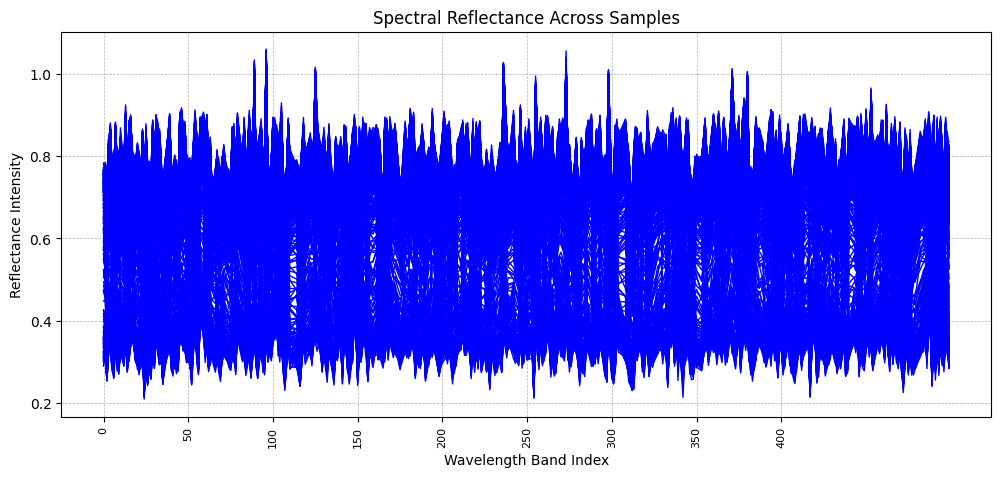

In [ ]:
# Visualizing the Spectral Bands

# Plot the Spectral reflectance
plt.figure(figsize=(12, 5))
plt.plot(X_cleaned, label="Average Reflectance", color='b', linewidth = 1)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Reflectance Intensity")
plt.title("Spectral Reflectance Across Samples")

# Formatting the x-axis to avoid overlap
plt.xticks(ticks=np.arange(0, len(X_cleaned), step=50), rotation=90, fontsize=8)

# Grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


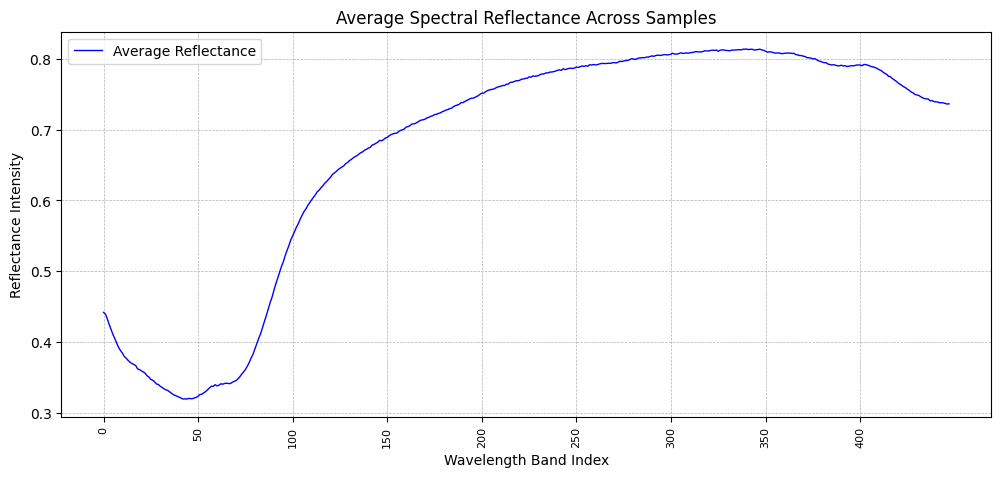

In [ ]:
# Visualizing the Spectral Bands

# Compute the average reflectance per wavelength band
mean_spectral_reflectance = X_cleaned.mean()

# Plot the average spectral reflectance
plt.figure(figsize=(12, 5))
plt.plot(mean_spectral_reflectance, label="Average Reflectance", color='b', linewidth = 1)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Reflectance Intensity")
plt.title("Average Spectral Reflectance Across Samples")

# Formatting the x-axis to avoid overlap
plt.xticks(ticks=np.arange(0, len(mean_spectral_reflectance), step=50), rotation=90, fontsize=8)

# Grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


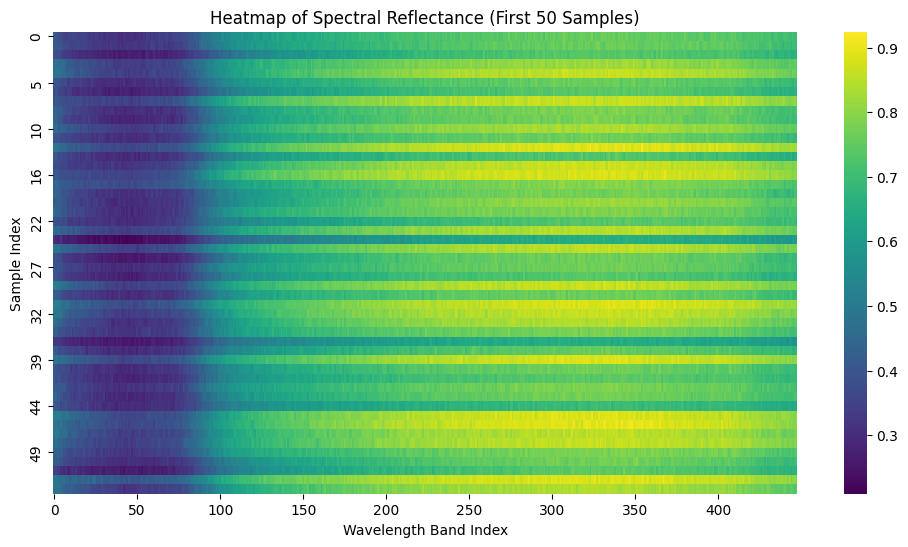

In [ ]:
# Heatmap of spectral reflectance for the first 50 samples
plt.figure(figsize=(12, 6))
sns.heatmap(X_cleaned.iloc[:50, :], cmap="viridis", xticklabels=50, yticklabels=5)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Sample Index")
plt.title("Heatmap of Spectral Reflectance (First 50 Samples)")
plt.show()

###Normalization and Standardization

In [ ]:
# Normalize Features (0 to 1)
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X_cleaned)

# Standardize Target Variable
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y_cleaned.values.reshape(-1, 1))

###Visualization of the Multiple Wavelengths before Normalization and Standardization

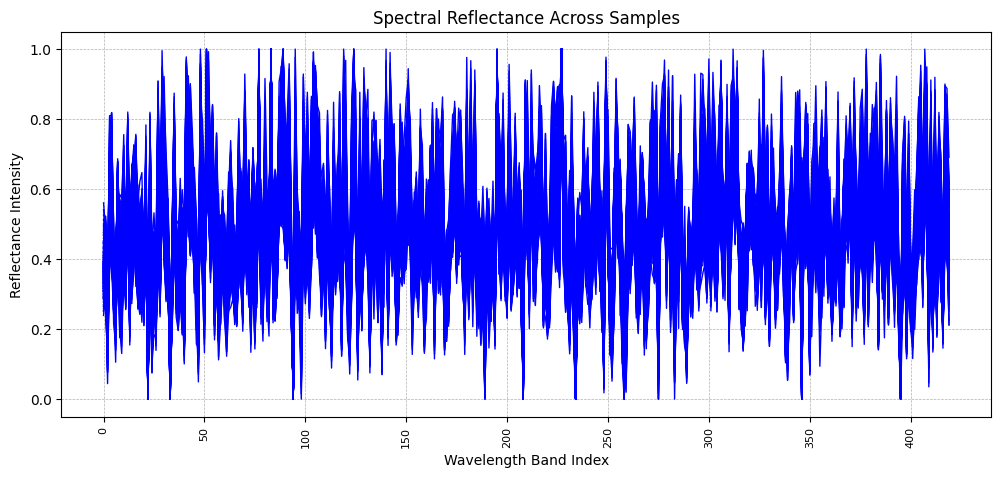

In [ ]:
# Visualizing the Spectral Bands

# Plot the Spectral reflectance
plt.figure(figsize=(12, 5))
plt.plot(X_normalized, label="Average Reflectance", color='b', linewidth = 1)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Reflectance Intensity")
plt.title("Spectral Reflectance Across Samples")

# Formatting the x-axis to avoid overlap
plt.xticks(ticks=np.arange(0, len(X_normalized), step=50), rotation=90, fontsize=8)

# Grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


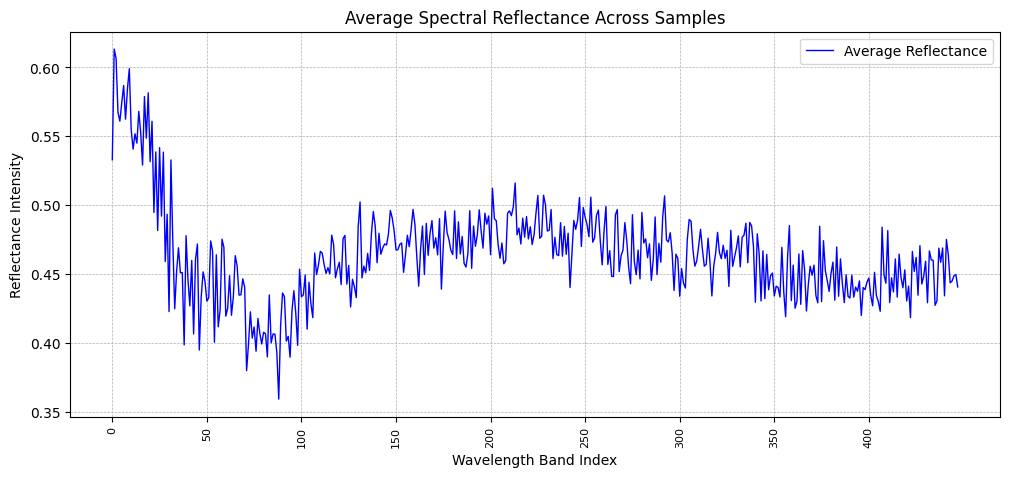

In [ ]:
# Visualizing the Spectral Bands

# Compute the average reflectance per wavelength band
mean_spectral_reflectance = X_normalized.mean(axis=0)

# Plot the average spectral reflectance
plt.figure(figsize=(12, 5))
plt.plot(mean_spectral_reflectance, label="Average Reflectance", color='b', linewidth = 1)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Reflectance Intensity")
plt.title("Average Spectral Reflectance Across Samples")

# Formatting the x-axis to avoid overlap
plt.xticks(ticks=np.arange(0, len(mean_spectral_reflectance), step=50), rotation=90, fontsize=8)

# Grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


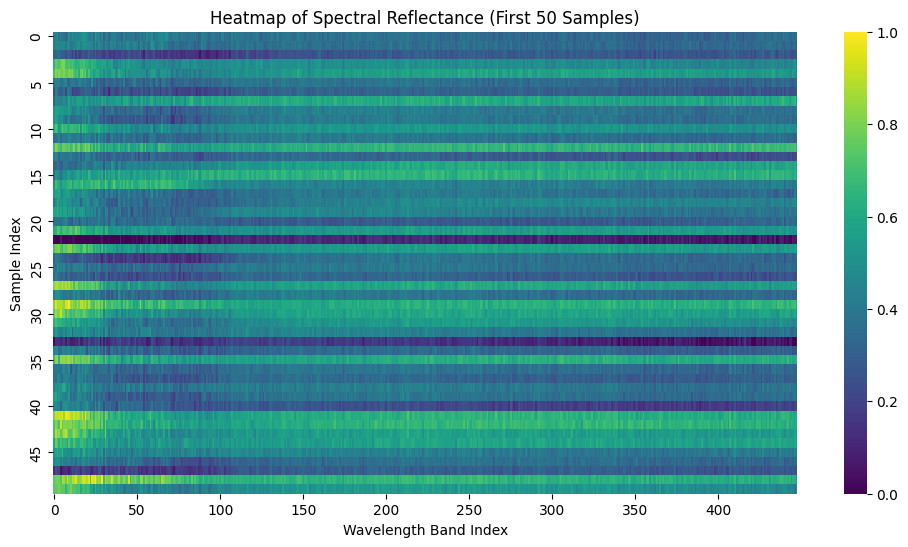

In [ ]:
# Heatmap of spectral reflectance for the first 50 samples
plt.figure(figsize=(12, 6))
sns.heatmap(X_normalized[:50, :], cmap="viridis", xticklabels=50, yticklabels=5)
plt.xlabel("Wavelength Band Index")
plt.ylabel("Sample Index")
plt.title("Heatmap of Spectral Reflectance (First 50 Samples)")
plt.show()

##Dimensionality Reduction

###Using the PCA

In [ ]:
# Apply PCA to Reduce Dimensionality
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_normalized)
explained_variance = pca.explained_variance_ratio_

In [ ]:
explained_variance

array([0.87735405, 0.0558873 , 0.01556587, 0.01219868])

###Visualization of Data after Performing PCA

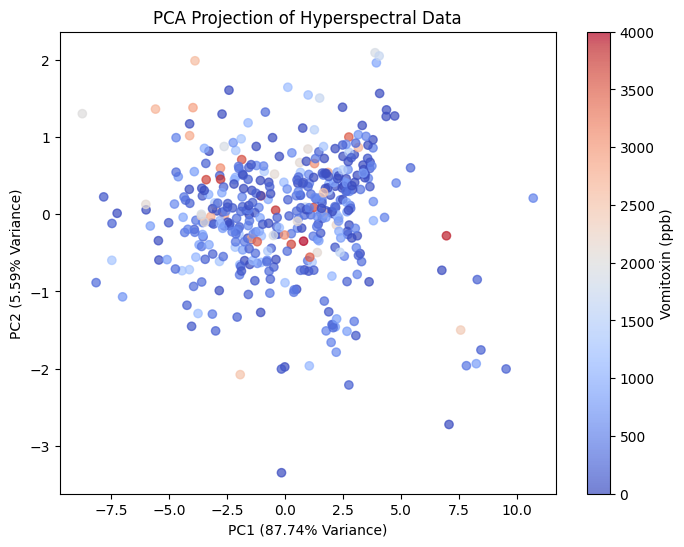

In [ ]:
# Visualizing PCA Projection
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_cleaned, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Vomitoxin (ppb)")
plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}% Variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}% Variance)")
plt.title("PCA Projection of Hyperspectral Data")
plt.show()

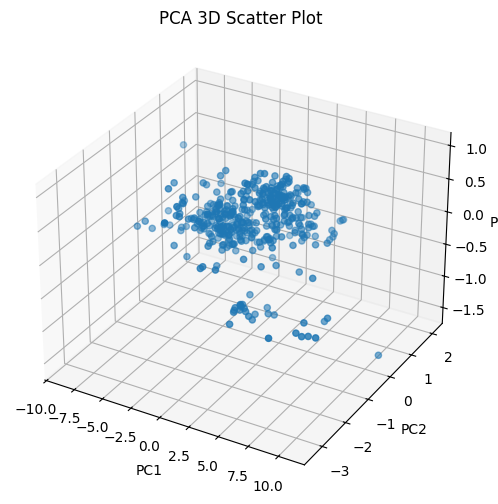

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA 3D Scatter Plot')
plt.show()

##Splitting of Dataset

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_standardized, test_size=0.2, random_state=42)

# Convert Data to PyTorch Tensor
X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

##Train loop

In [ ]:
def train_model(model, lr=0.001, batch_size=32, epochs=100):
    dataset = Data.TensorDataset(X_train_torch, y_train_torch)
    dataloader = Data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

##Model

###Multiple Linear Regression

In [ ]:
# Implement Multiple Linear Regression
regressor_mlr = LinearRegression()
regressor_mlr.fit(X_train, y_train)
y_pred_mlr = regressor_mlr.predict(X_test)
mae_mlr = mean_absolute_error(y_test, y_pred_mlr)
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
rmse_mlr = math.sqrt(mse_mlr)
r2_mlr = r2_score(y_test, y_pred_mlr)

###Support Vector Regressor

In [ ]:
# Implement Support Vector Regression (SVR) with Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'gamma': ['scale', 'auto']
}
random_search = RandomizedSearchCV(SVR(kernel='rbf'), param_grid, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=42)
random_search.fit(X_train, y_train)
best_svr = random_search.best_estimator_
y_pred_svr = best_svr.predict(X_test)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = math.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

###Random Forest Regressor

In [ ]:
# Define Random Forest Model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train.ravel())

# Best Model
best_rf_model = random_search.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Compute Metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = math.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for Random Forest Classifier: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}
Mean Absolute Error (MAE) for Random Forest Classifier: 0.7148
Root Mean Squared Error (RMSE) for Random Forest Classifier: 0.9006
R² Score for Random Forest Classifier: -0.0731


###XGBoost Regressor

In [ ]:
# Define XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train.ravel())

# Best Model
best_xgb_model = random_search.best_estimator_

# Predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Compute Metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = math.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for XGBoost Classifier: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Mean Absolute Error (MAE) for XGBoost Classifier: 0.6785
Root Mean Squared Error (RMSE) for XGBoost Classifier: 0.8154
R² Score for XGBoost Classifier: 0.1203


###Convolutional Neural Network

In [ ]:
# Define CNN Model with Adjusted Layers
class CNNModel(nn.Module):
    def __init__(self, input_size):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Compute final feature size after 3 pooling layers
        feature_size = input_size // (2 ** 2)  # Each pooling halves the size
        feature_size = max(1, feature_size)
        self.fc1 = nn.Linear(128 * feature_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        #x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x



# Hyperparameter Tuning
best_model = None
best_score = float('inf')
best_params = {}

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            model_cnn = CNNModel(X_train.shape[1])
            model_cnn = train_model(model_cnn, lr, batch_size, epochs)
            y_pred = model_cnn(X_test_torch).detach().numpy().flatten()
            score = mean_absolute_error(y_test, y_pred)
            if score < best_score:
                best_score = score
                best_model = model_cnn
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

# Evaluate Best Model
y_pred_cnn = best_model(X_test_torch).detach().numpy().flatten()
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = math.sqrt(mse_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Best Parameters for CNN: {'lr': 0.1, 'batch_size': 64, 'epochs': 150}
Mean Absolute Error (MAE) for CNN: 0.6533
Root Mean Squared Error (RMSE) for CNN: 0.8704
R² Score for CNN: -0.0024


###Convolutional Neural Network with Attension mechanism

In [ ]:
# Define CNN Model with Attention Mechanism
class CNNWithAttention(nn.Module):
    def __init__(self, input_size):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.attention = nn.Linear(16 * (input_size // 2), 16 * (input_size // 2))
        self.softmax = nn.Softmax(dim=1)
        self.fc1 = nn.Linear(16 * (input_size // 2), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        attn_weights = self.softmax(self.attention(x))
        x = x * attn_weights  # Apply attention weights
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameter Tuning
best_model = None
best_score = float('inf')
best_params = {}

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30]
}

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            model_cnn_attn = CNNWithAttention(X_train.shape[1])
            model_cnn_attn = train_model(model_cnn, lr, batch_size, epochs)
            y_pred = model_cnn_attn(X_test_torch).detach().numpy().flatten()
            score = mean_absolute_error(y_test, y_pred)
            if score < best_score:
                best_score = score
                best_model = model_cnn_attn
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

# Evaluate Best Model
y_pred_cnn_attn = best_model(X_test_torch).detach().numpy().flatten()
mae_cnn_attn = mean_absolute_error(y_test, y_pred_cnn_attn)
mse_cnn_attn = mean_squared_error(y_test, y_pred_cnn_attn)
rmse_cnn_attn = math.sqrt(mse_cnn_attn)
r2_cnn_attn = r2_score(y_test, y_pred_cnn_attn)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Best Parameters for CNN with Attn: {'lr': 0.1, 'batch_size': 16, 'epochs': 20}
Mean Absolute Error (MAE) for CNN with Attn: 0.7255
Root Mean Squared Error (RMSE) for CNN with Attn: 0.8920
R² Score for CNN with Attn: -0.0526


###Long Short-Term Memory (LSTM)

In [ ]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out[:, -1, :])  # Use last output for regression
        return x


# Hyperparameter Tuning
best_model = None
best_score = float('inf')
best_params = {}

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            model_lstm = LSTMModel(X_train.shape[1])
            model_lstm = train_model(model_cnn, lr, batch_size, epochs)
            y_pred = model_lstm(X_test_torch).detach().numpy().flatten()
            score = mean_absolute_error(y_test, y_pred)
            if score < best_score:
                best_score = score
                best_model = model_lstm
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

# Evaluate Best Model
y_pred_lstm = best_model(X_test_torch).detach().numpy().flatten()
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Best Parameters for LSTM: {'lr': 0.1, 'batch_size': 16, 'epochs': 50}
Mean Absolute Error (MAE) for LSTM: 0.7260
Root Mean Squared Error (RMSE) for LSTM: 0.8922
R² Score for LSTM: -0.0530


###Long Short-Term Memory(LSTM) with Attention Mechanism

In [ ]:
# Define LSTM with Attention
class LSTMAttention(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2):
        super(LSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attn = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = self.softmax(self.attn(lstm_out))
        attn_applied = torch.sum(lstm_out * attn_weights, dim=1)
        output = self.fc(attn_applied)
        return output

# Hyperparameter Tuning
best_model = None
best_score = float('inf')
best_params = {}

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [100, 200, 300]
}

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            model_lstm_attn = LSTMAttention(X_train.shape[1])
            model_lstm_attn = train_model(model_cnn, lr, batch_size, epochs)
            y_pred = model_lstm_attn(X_test_torch).detach().numpy().flatten()
            score = mean_absolute_error(y_test, y_pred)
            if score < best_score:
                best_score = score
                best_model = model_lstm_attn
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

# Evaluate Best Model
y_pred_lstm_attn = best_model(X_test_torch).detach().numpy().flatten()
mae_lstm_attn = mean_absolute_error(y_test, y_pred_lstm_attn)
mse_lstm_attn = mean_squared_error(y_test, y_pred_lstm_attn)
rmse_lstm_attn = math.sqrt(mse_lstm_attn)
r2_lstm_attn = r2_score(y_test, y_pred_lstm_attn)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Best Parameters for LSTM with Attn: {'lr': 0.1, 'batch_size': 16, 'epochs': 300}
Mean Absolute Error (MAE) for LSTM with Attn: 0.7542
Root Mean Squared Error (RMSE) for LSTM with Attn: 0.9058
R² Score for LSTM with Attn: -0.0854


###Multi-layer Perceptron

In [ ]:
# Convert Data to PyTorch Tensor
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define Fully Connected Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()

        self.batch_norm = nn.BatchNorm1d(input_shape)

        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)

        self.dropout1 = nn.Dropout(0.2)

        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 64)

        self.dropout2 = nn.Dropout(0.2)

        self.fc9 = nn.Linear(64, 32)
        self.fc10 = nn.Linear(32, 32)
        self.fc11 = nn.Linear(32, 32)
        self.fc12 = nn.Linear(32, 32)

        self.output = nn.Linear(32, output_shape)

    def forward(self, x):
        x = self.batch_norm(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = self.dropout1(x)

        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))

        x = self.dropout2(x)

        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x))

        x = self.output(x)
        return x  # Removed softmax, since regression does not need it

# Hyperparameter Tuning for Neural Network
best_model = None
best_score = float('inf')
best_params = {}

param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 150]
}

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            model_nn = NeuralNetwork(X_train.shape[1], 1)
            model_nn = train_model(model_nn, lr, batch_size, epochs)
            y_pred = model_nn(X_test_torch).detach().numpy().flatten()
            score = mean_absolute_error(y_test, y_pred)
            if score < best_score:
                best_score = score
                best_model = model_nn
                best_params = {'lr': lr, 'batch_size': batch_size, 'epochs': epochs}

# Evaluate Best Model
y_pred_nn = best_model(X_test_torch).detach().numpy().flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = math.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Best Parameters for Neural Network: {'lr': 0.1, 'batch_size': 64, 'epochs': 100}
Mean Absolute Error (MAE) for Neural Network: 0.5588
Root Mean Squared Error (RMSE) for Neural Network: 0.9323
R² Score for Neural Network: -0.1498


##Evaluation and Results

In [ ]:
df = pd.DataFrame({
    'Actual': y_test.ravel(),
    'Predicted_mlr': y_pred_mlr.ravel(),
    'Predicted_svr': y_pred_svr.ravel(),
    'Predicted_rf': y_pred_rf.ravel(),
    'Predicted_xgb': y_pred_xgb.ravel(),
    'Predicted_cnn': y_pred_cnn.ravel(),
    'Predicted_cnn_attn': y_pred_cnn_attn.ravel(),
    'Predicted_lstm': y_pred_lstm.ravel(),
    'Predicted_lstm_Attn': y_pred_lstm_attn.ravel(),
    'Predicted_nn': y_pred_nn.ravel()
})

df

,Actual,Predicted_mlr,Predicted_svr,Predicted_rf,Predicted_xgb,Predicted_cnn,Predicted_cnn_attn,Predicted_lstm,Predicted_lstm_Attn,Predicted_nn
0,-0.776181,-0.234316,-0.136032,-0.076600,-0.102543,-0.10057,0.056429,0.057352,0.111237,-0.47939
1,3.333953,0.184616,-0.261983,2.010705,1.739588,-0.10057,0.056429,0.057352,0.111237,-0.47939
2,-0.776181,-0.016615,-0.365356,-0.504022,-0.235282,-0.10057,0.056429,0.057352,0.111237,-0.47939
3,0.045846,0.369763,0.159013,0.690482,0.424110,-0.10057,0.056429,0.057352,0.111237,-0.47939
4,-0.776181,0.107899,0.039876,0.133551,-0.021345,-0.10057,0.056429,0.057352,0.111237,-0.47939
...,...,...,...,...,...,...,...,...,...,...
79,-0.776181,0.009726,-0.258500,-0.058480,-0.122449,-0.10057,0.056429,0.057352,0.111237,-0.47939
80,2.629359,0.390044,0.022849,1.015789,0.432749,-0.10057,0.056429,0.057352,0.111237,-0.47939
81,-0.071586,0.222516,0.168824,0.509023,0.230668,-0.10057,0.056429,0.057352,0.111237,-0.47939
82,-0.541316,-0.075155,-0.323721,-0.123474,-0.068027,-0.10057,0.056429,0.057352,0.111237,-0.47939


###Evaluation Metrics and Result

In [ ]:
# Store Model Metrics
results = []
results.append(["Multiple Regression", mae_mlr, rmse_mlr, r2_mlr])
results.append(["Support Vector Regression", mae_svr, rmse_svr, r2_svr])
results.append(["XGBoost", mae_xgb, rmse_xgb, r2_xgb])
results.append(["Random Forest Classifier", mae_rf, rmse_rf, r2_rf])
results.append(["CNN Without Attention", mae_cnn, rmse_cnn, r2_cnn])
results.append(["CNN With Attention", mae_cnn_attn, rmse_cnn_attn, r2_cnn_attn])
results.append(["LSTM Without Attention", mae_lstm, rmse_lstm, r2_lstm])
results.append(["LSTM With Attention", mae_lstm_attn, rmse_lstm_attn, r2_lstm_attn])
results.append(["Neural Network", mae_nn, rmse_nn, r2_nn])

# Convert Results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R² Score"])

In [ ]:
metrics_df

,Model,MAE,RMSE,R² Score
0,Multiple Regression,0.663344,0.830716,0.087034
1,Support Vector Regression,0.608705,0.888708,-0.044883
2,XGBoost,0.678535,0.815421,0.120342
3,Random Forest Classifier,0.714779,0.900628,-0.073102
4,CNN Without Attention,0.653290,0.870440,-0.002369
5,CNN With Attention,0.725516,0.891965,-0.052556
6,LSTM Without Attention,0.725999,0.892172,-0.053044
7,LSTM With Attention,0.754225,0.905789,-0.085434
8,Neural Network,0.558795,0.932261,-0.149807


###Scatter Plot

In [ ]:
# Scatter Plot Function
def plot_results(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
    plt.plot([-3, 3], [-3, 3], '--r', linewidth=2, label='Ideal Fit')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.legend()
    plt.show()

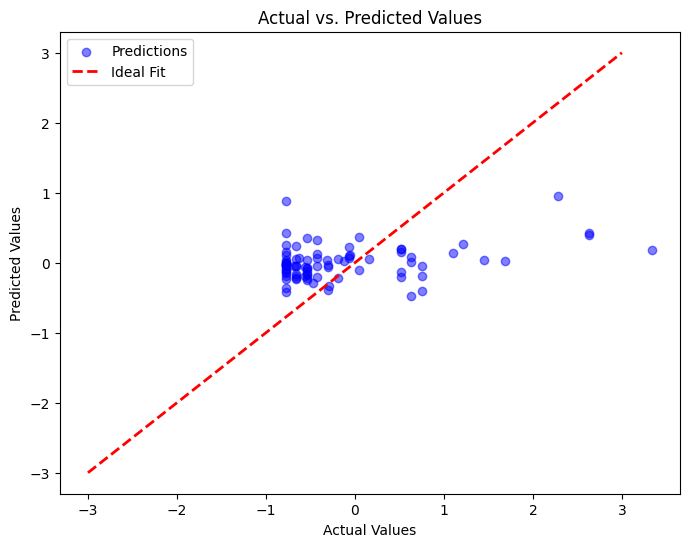

In [ ]:
plot_results(y_test, y_pred_mlr)